In [1]:
pip install catboost

     |████████████████████████████████| 67.4 MB 28 kB/s 


In [2]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,make_scorer,precision_score,recall_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/joshuasir/datasets/main/stock-market-train-clean.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/joshuasir/datasets/main/stock-market-test-clean.csv')

In [6]:
df.head()

,SMA,EMA,WMA,RSI,MOM,STC,CCI,Target,MACD
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,1
2,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0


In [68]:
X = df.copy()
y = X.pop('Target')
X_valid = df_test.copy()
y_valid = X_valid.pop('Target')

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,stratify=y,random_state=42)

In [8]:
y.value_counts()

0    51487
1    31885
Name: Target, dtype: int64

we will be using cross validation and precision as our metric since our data is unbalance

## Baseline Model

In [9]:
model = DummyClassifier(strategy='stratified')


scoring = {'Accuracy': 'accuracy',
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
    }


scores = cross_validate(model, X_train, y_train,
                              cv=5,
                              scoring=scoring)

print("Precision scores:\n", scores['test_Precision'].mean())
print("Recall scores:\n", scores['test_Recall'].mean())
print("F1 scores:\n", scores['test_F1'].mean())

# print('Dummy Classifier :', model.score(y_test,pred))
# print(classification_report(y_test,pred))

Precision scores:
 0.501792520537453
Recall scores:
 0.5018022038372524
F1 scores:
 0.5017933596229271


## Comparing Model

In [10]:

def train(classifier,name='',graph=False):
    
    scoring = {
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
           'ROC_AUC'  : 'roc_auc'
    }
    score_dict = cross_validate(classifier, X_train, y_train,
                              cv=10,
                              scoring=scoring)
    
    scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
    scores = scores.append(pd.Series({ 
                                      'Model' : name,
                                      # 'Accuracy' : score_dict['test_Accuracy'].mean(),
                                      'Precision' : score_dict['test_Precision'].mean(),
                                      'Recall' : score_dict['test_Recall'].mean(),
                                      'F1' : score_dict['test_F1'].mean(),
                                      'ROC AUC' : score_dict['test_ROC_AUC'].mean()
    }),ignore_index=True)
 
    return scores

In [52]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer


models =  { "Decision Tree" : DecisionTreeClassifier(),
            "Random Forest" : RandomForestClassifier(),
            "XGBoost" : XGBClassifier(), 
            "LogisticRegression" : LogisticRegression(max_iter=1200), 
            "CatBoost" :CatBoostClassifier(verbose=False) ,
            'LGBM' : LGBMClassifier(),
            'KNeighbors' : KNeighborsClassifier(),
            'AdaBoost' : AdaBoostClassifier()
            }

scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
# probability = {}

for model in models:
  scores = scores.append(train(models[model],name=model))

In [12]:
scores.sort_values('Precision',ascending=False).reset_index(drop=True)

,Model,Precision,Recall,F1,ROC AUC
0,XGBoost,0.613336,0.603996,0.605559,0.670388
1,AdaBoost,0.608514,0.584967,0.582144,0.664655
2,LogisticRegression,0.608458,0.584914,0.582083,0.665045
3,LGBM,0.607344,0.590921,0.589758,0.668659
4,Decision Tree,0.606813,0.591238,0.590530,0.667655
5,CatBoost,0.606548,0.591104,0.590413,0.667688
6,Random Forest,0.606053,0.590224,0.589469,0.667843
7,KNeighbors,0.584757,0.580090,0.576272,0.615130


XGBoost seems to be the best model here

In [13]:
cross_validate(XGBClassifier(), X_train, y_train, cv=10, scoring='precision_macro')['test_score'].mean()

0.6143927427878876

## Model Tuning and Train

In [17]:

param_grid = {
    'max_depth':[5,6],
    'min_child_weight':[5,6],
    'subsample':[.6,.5,.4],
    'n_estimators':[500,200],
    'colsample_bytree':[.5,.7,.2],
    'learning_rate':[.05,.1]
}

grid = GridSearchCV(estimator=XGBClassifier(),param_grid = param_grid,cv=5)
grid.fit(X_train,y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.5, 0.7, 0.2],
                         'learning_rate': [0.05, 0.1], 'max_depth': [5, 6],
                         'min_child_wei

In [18]:
grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 500,
 'subsample': 0.5}

In [69]:
model = XGBClassifier(max_depth=5, subsample= .5,colsample_bytree=.5,learning_rate=.1,min_child_weight=5,n_estimators=500)
history = model.fit(X_train,y_train)
pred = model.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     15446
           1       0.53      0.52      0.52      9566

    accuracy                           0.64     25012
   macro avg       0.62      0.62      0.62     25012
weighted avg       0.64      0.64      0.64     25012



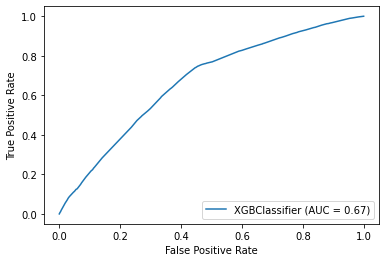

In [70]:
from sklearn import metrics

metrics.plot_roc_curve(model, X_test, y_test)

In [98]:
def evaluation(model,X,y,threshold=.3):
  score = model.predict_proba(X)[:, 1]
  result = [(i > threshold) for i in score]
  print(classification_report(y, result, labels=[0,1]))
  print('Precision avg :', precision_score(y,result,average='weighted'))
  print('Recall avg :', recall_score(y,result,average='weighted'))

In [99]:
evaluation(model,X_test,y_test)

              precision    recall  f1-score   support

           0       0.78      0.53      0.63     15446
           1       0.50      0.76      0.60      9566

    accuracy                           0.62     25012
   macro avg       0.64      0.64      0.62     25012
weighted avg       0.67      0.62      0.62     25012

Precision avg : 0.6719099377785426
Recall avg : 0.6174636174636174


In [41]:
pip install shap

     |████████████████████████████████| 356 kB 5.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491645 sha256=a8b7c94a35d4c2be0ad5d484d77fd96ae1a45a4c9c30015fb7c396bf0417a698
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


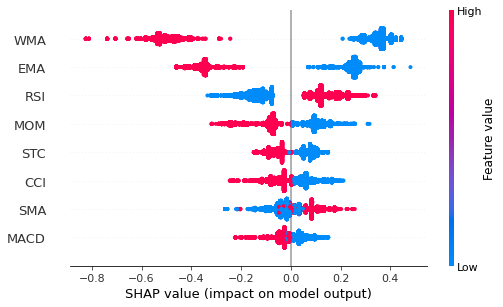

In [42]:
import shap  

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test)

## Evaluation on Unseen Values

In [100]:
evaluation(model,X_valid,y_valid)

              precision    recall  f1-score   support

           0       0.70      0.58      0.64      9915
           1       0.67      0.77      0.72     10935

    accuracy                           0.68     20850
   macro avg       0.69      0.68      0.68     20850
weighted avg       0.68      0.68      0.68     20850

Precision avg : 0.6847882302406751
Recall avg : 0.6824460431654676


The result is more or less are similar from the distribution although the scores are pretty low and the weighted average is really far from the test we still have a decent a near precision score from the test, around 68%.